## References:
- [Beginner's Guide to Boltzmann Machines in PyTorch](https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/)
- [PyTorch Autograd - Understanding the heart of PyTorch’s magic](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95)
- [Learnergy Github rbm.py](https://github.com/gugarosa/learnergy/blob/139acf7324c0d164e9cf0f60bd3f351ab298144d/learnergy/models/bernoulli/rbm.py#L21)

## Experiments
1. Adding no_grad() has no significant effect when k=1, but costs less time when k=5.

In [2]:
# load modules in other files
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from __future__ import unicode_literals, print_function, division

# autoreload self-defined modules
%load_ext autoreload
%autoreload 2

from data_util import utils
from data_util import config
from data_util.batcher import Batcher
from data_util.data import Vocab
from data_util.utils import calc_running_avg_loss
from training_ptr_gen.train_util import get_rbm_input_from_batch, get_rbm_output_from_batch

from textRBM import TextRBM
from training_ptr_gen.train import Train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda:0,1")
train_processor = Train()
vocab = train_processor.vocab
iter, running_avg_loss = train_processor.setup_train(None)
batch = train_processor.batcher.next_batch()
docs_word_count = get_rbm_input_from_batch(batch, vocab, True, device)

max_size of vocab was specified as 50000; we now have 50000 words. Stopping reading.
Finished constructing vocabulary of 50000 total words. Last word added: 16-years-old

INFO:tensorflow:Bucket queue size: 0, Input queue size: 0



# Debug nan in loss and weight

In [2]:
def save(save_dir, iter, model):
    ckpt_dict = {'model_state': model.state_dict(), 'iter': iter}
    ckpt_path = os.path.join(save_dir, "iter_%d.pth.tar" % iter)
    torch.save(ckpt_dict, ckpt_path)

In [3]:
device = torch.device("cpu")
train_processor = Train()
vocab = train_processor.vocab

import time
start_time = time.time()
rbm = TextRBM(k=1).to(device)
save_dir = "/home/yang6367/gitrepos/pointer_summarizer/train_textRBM/save/rbm%d" % int(start_time)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
train_op = optim.SGD(rbm.parameters(),0.1)

iter = 0
niters = 100000
loss_ = []
while iter < niters:
    batch = train_processor.batcher.next_batch()
    docs_word_count = get_rbm_input_from_batch(batch, vocab, False, device)

    v,v1 = rbm(docs_word_count.float())
    loss = rbm.free_energy(v) - rbm.free_energy(v1)
    loss_.append(loss.data)
    train_op.zero_grad()
    loss.backward()
    train_op.step()

    iter += 1

    # update k
    if iter % 20000 == 0:
        rbm.k = int(iter / 20000) + 1
    if iter % 500 == 0:
        print("Training loss for %d iter: %.5f" % (iter, np.mean(loss_)))
        loss_ = []
    if iter % 4000 == 0:
        save(save_dir, iter, rbm)

print("%f seconds" % (time.time() - start_time))


max_size of vocab was specified as 50000; we now have 50000 words. Stopping reading.
Finished constructing vocabulary of 50000 total words. Last word added: 16-years-old

INFO:tensorflow:Bucket queue size: 0, Input queue size: 0

INFO:tensorflow:Bucket queue size: 100, Input queue size: 800


# Load learned model and generate latent representations for a batch

In [2]:
device = torch.device("cpu")
vocab = Vocab(config.vocab_path, config.vocab_size)
batcher = Batcher(config.train_data_path, vocab, mode='train',
                            batch_size=8, single_pass=False)

import time
start_time = time.time()
rbm = TextRBM(k=1)

ckpt_path = "/home/yang6367/gitrepos/pointer_summarizer/train_textRBM/save/rbm1618806575/iter_28000.pth.tar"
ckpt_dict = torch.load(ckpt_path, map_location="cpu")
rbm.load_state_dict(ckpt_dict['model_state'])
rbm = rbm.to(device)




max_size of vocab was specified as 50000; we now have 50000 words. Stopping reading.
Finished constructing vocabulary of 50000 total words. Last word added: 16-years-old

INFO:tensorflow:Bucket queue size: 0, Input queue size: 1


In [3]:

vocab = Vocab(config.vocab_path, config.vocab_size)
batcher = Batcher(config.train_data_path, vocab, mode='train',
                            batch_size=8, single_pass=False)

max_size of vocab was specified as 50000; we now have 50000 words. Stopping reading.
Finished constructing vocabulary of 50000 total words. Last word added: 16-years-old

INFO:tensorflow:Bucket queue size: 0, Input queue size: 0


In [7]:
device = utils.get_devices([2])
batch = batcher.next_batch()
get_rbm_output_from_batch(batch, vocab, True, device)


tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]], device='cuda:2')

In [3]:
batch = batcher.next_batch()
docs_word_count = get_rbm_input_from_batch(batch, vocab, False, device)

v,v1 = rbm(docs_word_count.float())


In [7]:
with torch.no_grad():
    _, sample_h = rbm.v_to_h(docs_word_count.float(), docs_word_count.float().sum(-1).int())
sample_h

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [6]:
sample_h.shape

torch.Size([8, 200])

In [13]:
print(not True and True)
print(not True and False)
print((not True) and False)
print(not (True and False))

False
False
False
True
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input queue size: 800
INFO:tensorflow:Bucket queue size: 100, Input q

In [8]:
with open("/home/yang6367/gitrepos/cnn-dailymail/top15k_words.txt", "r") as f:
    top15k_words = [word.rstrip() for word in f.readlines()]


In [23]:
words = [word for (word, count) in zip(top15k_words, v[0].tolist()) if count != 0]
words

['say',
 'year',
 'one',
 "n't",
 'make',
 'go',
 'new',
 'two',
 'last',
 'first',
 'use',
 'work',
 'see',
 'call',
 'include',
 'three',
 'month',
 'even',
 'good',
 'start',
 'u.s.',
 'run',
 'four',
 'put',
 'much',
 "'re",
 'service',
 'five',
 'stop',
 '10',
 'statement',
 'large',
 'test',
 'wednesday',
 'air',
 'power',
 'le',
 'spokesman',
 'different',
 'britain',
 'flight',
 'third',
 'announce',
 'fly',
 'market',
 'series',
 'plane',
 '11',
 'february',
 'sure',
 'measure',
 'common',
 'response',
 'perform',
 'performance',
 'burn',
 'crew',
 'texas',
 'conduct',
 'main',
 'oil',
 'airline',
 'plant',
 'pilot',
 'aircraft',
 'cold',
 'fuel',
 'exercise',
 'engineer',
 'scott',
 'traditional',
 'jet',
 'mix',
 'scale',
 'engine',
 'commercial',
 'zealand',
 'cruise',
 'combine',
 'examine',
 'tank',
 'houston',
 'entirely',
 'grade',
 'atlantic',
 'carrier',
 'manufacturer',
 'equal',
 'combination',
 'virgin',
 'outstanding',
 'boeing',
 'airway',
 'hub',
 'blend',
 'con

In [3]:
rbm.W

Parameter containing:
tensor([[-15.6649,   0.0989,  -0.0455,  ...,   0.0050,  -0.0001,  -0.0003],
        [  0.1898,   0.0276,   0.0165,  ...,   0.0113,   0.0006,   0.0051],
        [  0.1514,   0.0146,   0.0260,  ...,   0.0073,  -0.0073,   0.0062],
        ...,
        [-15.6751,   0.0930,  -0.0351,  ...,   0.0011,   0.0065,  -0.0161],
        [  0.8893,   0.9279,   0.8847,  ...,  -0.2754,  -0.3079,  -0.2178],
        [-15.4331,   0.1223,  -0.0113,  ...,   0.0073,   0.0089,   0.0063]],
       requires_grad=True)

In [5]:
iter = 20000
int(iter / 20000)

1

### A small example illustrating multinomial sampling

In [58]:
u = torch.Tensor([None])
print(u)

p = torch.Tensor([0.2, 0.3, 0.4, 0.1])
p = torch.cat((torch.Tensor([0]), p), 0)
print(p)

c = torch.cumsum(p, dim=0)
print(c)

g = F.relu(torch.sign(c - u))
print(g)

x = (1 - g[:-1]) * g[1:]
print(x)

tensor(nan, grad_fn=<SelectBackward>)
tensor([0.0000, 0.2000, 0.3000, 0.4000, 0.1000])
tensor([0.0000, 0.2000, 0.5000, 0.9000, 1.0000])
tensor([0., 0., 0., 0., 0.], grad_fn=<ReluBackward>)
tensor([0., 0., 0., 0.], grad_fn=<ThMulBackward>)


TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [8]:
batch_size = 8
n_vis = 5
n_hin = 4

v = Variable(torch.randint(2, (batch_size, n_vis))).float()
h = Variable(torch.rand(batch_size, n_hin)).float()
W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
h_bias = nn.Parameter(torch.rand(n_hin))
v_bias = nn.Parameter(torch.rand(n_vis))
d = v.sum(-1).int()
print(h_bias)
print(d)

p_h = torch.sigmoid(F.linear(v, W,h_bias) + torch.mm(d.float().unsqueeze(-1), h_bias.unsqueeze(0)))

sample_h = sample_bernoulli(p_h)
print(p_h)
print(sample_h)
print(p_h.shape)
print(sample_h.shape)

print("="*40)
p_v = torch.nn.Softmax(dim=-1)(F.linear(h,W.t(),v_bias))
print(p_v)
print(p_v.shape)
sample_v = torch.stack([torch.stack([sample_multinomial(p_v_i) for _ in range(d_i)]).sum(0) for (p_v_i, d_i) in zip(p_v, d)])
print(sample_v)
print(sample_v.shape)


Parameter containing:
tensor([0.9127, 0.1914, 0.7541, 0.1122], requires_grad=True)
tensor([4, 5, 3, 3, 4, 3, 4, 3], dtype=torch.int32)
tensor([[0.9895, 0.7263, 0.9774, 0.6362],
        [0.9958, 0.7627, 0.9892, 0.6644],
        [0.9747, 0.6844, 0.9530, 0.6156],
        [0.9746, 0.6821, 0.9534, 0.6086],
        [0.9897, 0.7231, 0.9773, 0.6382],
        [0.9747, 0.6848, 0.9534, 0.6104],
        [0.9896, 0.7253, 0.9776, 0.6358],
        [0.9750, 0.6824, 0.9529, 0.6129]], grad_fn=<SigmoidBackward>)
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 0., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 0., 1., 1.]])
torch.Size([8, 4])
torch.Size([8, 4])
tensor([[0.2138, 0.1938, 0.1618, 0.2336, 0.1970],
        [0.2125, 0.1942, 0.1599, 0.2375, 0.1958],
        [0.2114, 0.1951, 0.1609, 0.2338, 0.1989],
        [0.2103, 0.1958, 0.1600, 0.2351, 0.1988],
        [0.2122, 0.1947, 0.1601, 0.2355, 0.1974],
    

In [79]:
torch.stack([torch.stack([sample_multinomial(p_v_i) for _ in range(d_i)]).sum(0) for (p_v_i, d_i) in zip(p_v, d)])

tensor([[0, 0, 1, 2, 0],
        [0, 0, 2, 0, 1],
        [0, 2, 0, 0, 0],
        [0, 1, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0],
        [1, 1, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [54]:
a
sample_v = torch.stack([sample_multinomial(p_v_i) for _ in range(d_i)]).sum(0)

TypeError: only integer tensors of a single element can be converted to an index

In [25]:
import time
start_time = time.time()
rbm = RBM(k=5)
train_op = optim.SGD(rbm.parameters(),0.1)

for epoch in range(10):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))  # 784 = 1 * 28 * 28
        sample_data = data.bernoulli()   # draw bernoulli variables using the probability in the tensor, input should be in the range of [0, 1].
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

print(f"--- {time.time() - start_time} seconds ---")

Training loss for 0 epoch: -4.336457252502441
Training loss for 1 epoch: -5.838414192199707
Training loss for 2 epoch: -3.686033010482788
Training loss for 3 epoch: -2.3657965660095215
Training loss for 4 epoch: -1.455875277519226
Training loss for 5 epoch: -0.9321050047874451
Training loss for 6 epoch: -0.409782350063324
Training loss for 7 epoch: -0.07795581966638565
Training loss for 8 epoch: 0.12475182861089706
Training loss for 9 epoch: 0.3909907042980194
--- 180.25444340705872 seconds ---


In [14]:
def show_and_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

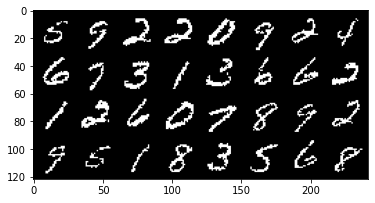

In [15]:
show_and_save("real",make_grid(v.view(32,1,28,28).data))

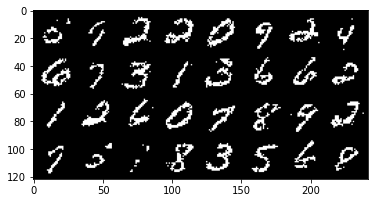

In [26]:
show_and_save("generate",make_grid(v1.view(32,1,28,28).data))

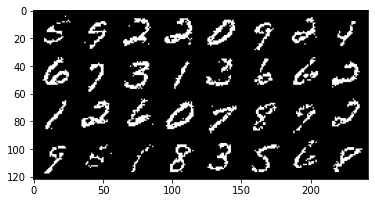

In [16]:
show_and_save("generate",make_grid(v1.view(32,1,28,28).data))

In [40]:
class RBM(nn.Module):
   def __init__(self,
               n_vis=784,
               n_hin=500,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))   # draw binary samples with p being the probablity of being 1, we can also use bernoulli, this implementation is just more bottom.
    
   def v_to_h(self,v):
        p_h = torch.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = torch.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v):
        p_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            p_v_,v_ = self.h_to_v(h_)
            p_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias) # torch.mv() performs a matrix-vector product
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [18]:
start_time = time.time()
rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(),0.1)

for epoch in range(10):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))  # 784 = 1 * 28 * 28
        # sample_data = data.bernoulli()   # draw bernoulli variables using the probability in the tensor, input should be in the range of [0, 1].
        
        v,v1 = rbm(data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

print(f"--- {time.time() - start_time} seconds ---")

Training loss for 0 epoch: -7.991797924041748
Training loss for 1 epoch: -5.800401210784912
Training loss for 2 epoch: -3.7071800231933594
Training loss for 3 epoch: -2.3971219062805176
Training loss for 4 epoch: -1.6108218431472778
Training loss for 5 epoch: -1.0678132772445679
Training loss for 6 epoch: -0.7031519412994385
Training loss for 7 epoch: -0.4269734025001526
Training loss for 8 epoch: -0.22924593091011047
Training loss for 9 epoch: -0.05957659333944321
--- 112.75786089897156 seconds ---


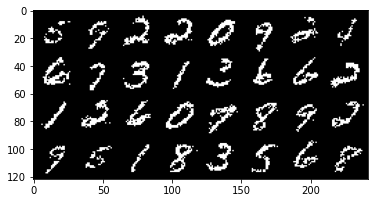

In [19]:
show_and_save("generate",make_grid(v1.view(32,1,28,28).data))

In [42]:
start_time = time.time()
rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(),0.1)

for epoch in range(10):
    loss_ = []
    mse_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))  # 784 = 1 * 28 * 28
        sample_data = data.bernoulli()   # draw bernoulli variables using the probability in the tensor, input should be in the range of [0, 1].
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        mse = torch.pow(v - v1, 2).sum(1).mean()
        loss_.append(loss.data)
        mse_.append(mse.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print(f"Epoch {epoch}: Training loss = {np.mean(loss_)}, MSE = {np.mean(mse_)}")

print(f"--- {time.time() - start_time} seconds ---")

Epoch 0: Training loss = -8.375116348266602, MSE = 71.58562469482422
Epoch 1: Training loss = -6.653524398803711, MSE = 50.429603576660156
Epoch 2: Training loss = -4.602795124053955, MSE = 45.00686264038086
Epoch 3: Training loss = -3.2427167892456055, MSE = 41.98382568359375
Epoch 4: Training loss = -2.2942237854003906, MSE = 40.03661346435547
Epoch 5: Training loss = -1.6626482009887695, MSE = 38.683135986328125
Epoch 6: Training loss = -1.0771689414978027, MSE = 37.68546676635742
Epoch 7: Training loss = -0.7818908095359802, MSE = 36.910499572753906
Epoch 8: Training loss = -0.578610897064209, MSE = 36.30099105834961
Epoch 9: Training loss = -0.2827174663543701, MSE = 35.766109466552734
--- 110.6157968044281 seconds ---


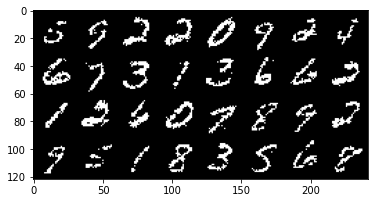

In [43]:
show_and_save("generate",make_grid(v1.view(32,1,28,28).data))